# Benchmark collection models

https://github.com/LoosC/Benchmark-Models/issues

In [1]:
import libsbml
import os
import sys
sys.path.insert(0, os.path.split(os.path.split(os.getcwd())[0])[0])
import pypesto
import sys
import amici
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pypesto.objective.amici_objective import (import_sbml_model, 
                                               amici_objective_from_measurement_file)

models = ['Bachmann_MSB2011', 'beer_MolBioSystems2014', 'boehm_JProteomeRes2014',
 'Borghans_BiophysChem1997', 'Brannmark_JBC2010', 'Bruno_JExpBio2016',
'Chen_MSB2009', 'Crauste_CellSystems2017', 'Elowitz_Nature2000',
'Fiedler_BMC2016', 'Fujita_SciSignal2010', 'Hass_PONE2017',
'Isensee_JCB2018', 'Lucarelli_CellSystems_2018',
'Merkle_PCB2016', 'Raia_CancerResearch2011',
'Schwen_PONE2014','Sneyd_PNAS2002', 'Sobotta_Frontiers2017',
'Swameye_PNAS2003', 'Weber_BMC2015','Zheng_PNAS2012']

In [2]:
# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LoosC/Benchmark-Models.git || (cd Benchmark-Models && git pull)

fatal: destination path 'Benchmark-Models' already exists and is not an empty directory.
Already up to date.


In [3]:
model_root = os.path.abspath(os.path.join('Benchmark-Models', 'hackathon_contributions_new_data_format'))

benchmark_model = 'Zheng_PNAS2012'
condition_filename = os.path.join(model_root, benchmark_model, f'experimentalCondition_{benchmark_model}.tsv')
measurement_filename = os.path.join(model_root, benchmark_model,f'measurementData_{benchmark_model}.tsv')
parameter_filename = os.path.join(model_root, benchmark_model, f'parameters_{benchmark_model}.tsv')
sbml_model_file = os.path.join(model_root, benchmark_model, f'model_{benchmark_model}_l2v4.xml')
model_name = f'model_{benchmark_model}'
model_output_dir = f'deleteme-{model_name}'

## Import model

In [4]:
rebuild = True
if rebuild:
    import_sbml_model(sbml_model_file=sbml_model_file,
                      condition_file=condition_filename,
                      measurement_file=measurement_filename,
                      model_output_dir=model_output_dir,
                      model_name=model_name)

libSBML Warning (SBML unit consistency): In situations where a mathematical expression contains literal numbers or parameters whose units have not been declared, it is not possible to verify accurately the consistency of the units in the expression. 
 The units of the <assignmentRule> <math> expression 'noiseParameter1_K27me0K36me0' cannot be fully checked. Unit consistency reported as either no errors or further unit errors related to this object may not be accurate.

libSBML Warning (SBML unit consistency): In situations where a mathematical expression contains literal numbers or parameters whose units have not been declared, it is not possible to verify accurately the consistency of the units in the expression. 
 The units of the <assignmentRule> <math> expression 'noiseParameter1_K27me0K36me1' cannot be fully checked. Unit consistency reported as either no errors or further unit errors related to this object may not be accurate.

libSBML Warning (SBML unit consistency): In situatio

In [5]:
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)

model = model_module.getModel()
model.requireSensitivitiesForAllParameters()

solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
solver.setSensitivityOrder(amici.SensitivityOrder_first)

print("Model parameters:", list(model.getParameterIds()))
print()
print("Model const parameters:", list(model.getFixedParameterIds()))
print()
print("Model outputs:   ", list(model.getObservableIds()))
print()
print("Model states:    ", list(model.getStateIds()))

Model parameters: ['inflowp', 'k00_01', 'k00_10', 'k01_00', 'k01_02', 'k01_11', 'k02_01', 'k02_03', 'k02_12', 'k03_02', 'k03_13', 'k10_00', 'k10_11', 'k10_20', 'k11_01', 'k11_10', 'k11_12', 'k11_21', 'k12_02', 'k12_11', 'k12_13', 'k12_22', 'k13_03', 'k13_12', 'k13_23', 'k20_10', 'k20_21', 'k20_30', 'k21_11', 'k21_20', 'k21_22', 'k21_31', 'k22_12', 'k22_21', 'k22_23', 'k22_32', 'k23_13', 'k23_22', 'k30_20', 'k30_31', 'k31_21', 'k31_30', 'k31_32', 'k32_22', 'k32_31', 'noiseParameter1_K27me0K36me0', 'noiseParameter1_K27me0K36me1', 'noiseParameter1_K27me0K36me2', 'noiseParameter1_K27me0K36me3', 'noiseParameter1_K27me1K36me0', 'noiseParameter1_K27me1K36me1', 'noiseParameter1_K27me1K36me2', 'noiseParameter1_K27me1K36me3', 'noiseParameter1_K27me2K36me0', 'noiseParameter1_K27me2K36me1', 'noiseParameter1_K27me2K36me2', 'noiseParameter1_K27me2K36me3', 'noiseParameter1_K27me3K36me0', 'noiseParameter1_K27me3K36me1', 'noiseParameter1_K27me3K36me2']

Model const parameters: ['dilution']

Model outpu

## Create objective function

In [6]:
#from pypesto.logging import log_to_console
#log_to_console()

In [7]:
# Create objective function instance from model and measurements
model.setParameterScale(amici.ParameterScaling_log10)
objective = amici_objective_from_measurement_file(amici_model=model, 
                                            condition_filename=condition_filename,
                                            measurement_filename=measurement_filename, 
                                            amici_solver=solver)

In [8]:
# load nominal parameters from parameter description file
parameter_df = pd.read_csv(parameter_filename, index_col=0, sep='\t')
nominal_x = parameter_df.loc[list(model.getParameterIds())].nominalValue.values
#nominal_x = np.power(10, nominal_x)
for i, p in enumerate(model.getParameterIds()):
    if p.startswith('noise'):
        nominal_x[i] = -2.63 #np.power(10, -2.63)
print(nominal_x)

[-1.52  3.   -0.63  2.68  0.28  0.42 -1.16 -5.   -5.   -5.    2.99 -5.
 -5.   -0.57 -5.   -5.    1.07 -5.   -5.   -0.97 -1.45 -1.97  2.65 -0.71
 -5.   -5.   -5.   -0.82 -5.   -1.45  3.   -5.   -1.27  2.63 -0.82 -5.
 -0.1  -5.   -5.   -0.55 -5.   -5.   -0.45 -0.2  -5.   -2.63 -2.63 -2.63
 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63 -2.63]


/home/dweindl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# evaluate with nominal parameters
llh = objective(x=nominal_x)
print(f'llh: {llh}, lh: {np.exp(llh)}')

llh: 55.13648091728291, lh: 8.820016832114285e+23


## Run optimization

In [10]:
# create optimizer object which contains all information for doing the optimization
optimizer = pypesto.ScipyOptimizer()

optimizer.solver = 'bfgs'

parameter_ids = model.getParameterIds()

problem = pypesto.Problem(objective=objective,
                          lb=-5*np.ones(len(parameter_ids)), ub=5*np.ones(len(parameter_ids)),
                          x_names=parameter_ids)


# do the optimization
result = pypesto.minimize(problem=problem,
                          optimizer=optimizer,
                          n_starts=10) # 200

In [11]:
fvals = result.optimize_result.get_for_key('fval')
fvals

[55.20859507954589,
 55.35587606185784,
 56.357451764521784,
 56.472416758014475,
 56.58130619074505,
 56.7290059532832,
 56.967050632686664,
 57.015097090042836,
 57.09347708912459,
 57.19037786020248]

In [12]:
x = result.optimize_result.get_for_key('x')
x

[array([-0.20548097, -0.80442738,  1.13231216, -2.51535584,  1.81034974,
        -1.55457457,  0.83790458, -2.3886584 ,  0.75851637, -0.54049967,
        -2.96562607, -2.89464263,  1.17281364, -2.18212298, -1.60820195,
        -1.40017617,  2.19075842, -1.72689585,  0.21399498,  0.84209718,
        -1.71381643, -2.06909873, -4.97266774,  4.67251888,  1.24550589,
        -3.92594292,  2.42467631,  1.10878891, -4.10315798, -2.5073944 ,
         0.46154425,  2.28140632, -2.87736621,  4.89565253, -2.77137661,
         4.41385743, -1.68635433,  2.34790248,  0.23657992,  2.36407905,
         2.82127212, -3.01992513, -0.6408944 ,  4.08637574,  3.28700401,
        -3.2783809 , -3.18924836, -0.22658208,  1.24071032,  1.66518359,
        -0.32157338,  4.44635731, -1.92119141,  2.77188823, -4.84186418,
        -3.27169616,  2.43884559,  0.80001427,  2.50021648, -4.83026236]),
 array([ 9.39043852e-01, -3.74080109e+00,  1.59181639e+00, -4.32448234e+00,
        -3.37766161e+00, -4.70740466e+00,  1.9

## Visualization
Create waterfall and parameter plot

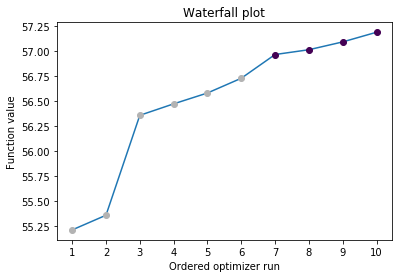

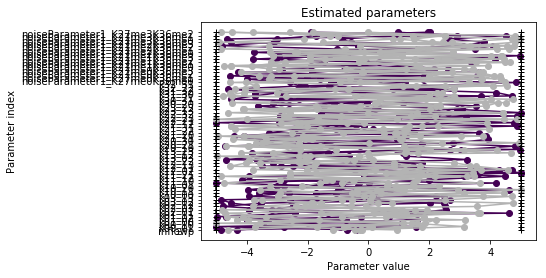

In [13]:
# waterfall, parameter space,
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)

### Save data simulated with optimal parameters 

In [14]:
# TODO: visualize goodness of fit
x = result.optimize_result.list[0]['x']
dfs = objective.simulations_to_measurement_df(x)

In [15]:
dfs

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParametersobservableTransformation,noiseParameters,observableTransformation
0,observable_K27me0K36me0,None,condition_0,4.345059e-02,0.0,None,NaN,1.0,None
1,observable_K27me0K36me0,None,condition_0,4.757446e-06,5.0,None,NaN,1.0,None
2,observable_K27me0K36me0,None,condition_0,4.595203e-06,10.0,None,NaN,1.0,None
3,observable_K27me0K36me0,None,condition_0,4.145404e-06,25.0,None,NaN,1.0,None
4,observable_K27me0K36me1,None,condition_0,1.850583e-02,0.0,None,NaN,1.0,None
5,observable_K27me0K36me1,None,condition_0,2.133369e-02,5.0,None,NaN,1.0,None
6,observable_K27me0K36me1,None,condition_0,2.060631e-02,10.0,None,NaN,1.0,None
7,observable_K27me0K36me1,None,condition_0,1.858933e-02,25.0,None,NaN,1.0,None
8,observable_K27me1K36me0,None,condition_0,3.805960e-02,0.0,None,NaN,1.0,None
9,observable_K27me1K36me0,None,condition_0,8.821250e-05,5.0,None,NaN,1.0,None
